<a href="https://colab.research.google.com/github/Gregory-lab-eng/python_Vistula/blob/main/Strakhov_75209_GPT2_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Poniższy kod służy do przetestowania procesu tokenizacji i detokenizacji modelu jezykowego opartego na architekturze transformera, z mechanizmem atencji

In [1]:
#import niezbednych pakietow i bibliotek
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
#zaladowanie modelu na dostepne urzadzenie CPU lub GPU (cuda:0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
#wydruk parametrow modelu
###ZADANIE1: wyszukajcie znaczenia hiperparametrów modelu: wte, wpe, drop, c_attn, c_proj, c_fc, c_proj
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


(wte): Embedding(50257, 768)

(wpe): Embedding(1024, 768)

(drop): Dropout(p=0.1, inplace=False)

(c_attn): Conv1D(nf=2304, nx=768)

(c_proj): Conv1D(nf=768, nx=768)

(c_fc): Conv1D(nf=3072, nx=768)

(c_proj): Conv1D(nf=768, nx=3072)


In [4]:
#zainicjowanie tokenizera
#ZADANIE2: Wyszukajcie informacji czym jest attention_mask oraz jakie jest jej zastosowanie
prompt = "Once upon a time"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[7454, 2402,  257,  640]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

attention_mask to tensor używany w modelach typu Transformer, który mówi modelowi, na które tokeny ma zwracać uwagę, a które ignorować.
attention_mask: tensor([[1, 1, 1, 1]]) - oznacza, że wszystkie cztery tokeny są ważne i żaden nie jest paddingiem.
Maska mówi mechanizmowi attention, które tokeny mogą patrzeć na które.
Bez niej model mógłby analizować śmieciowe dane. Maskowanie paddingu zmniejsza liczbę niepotrzebnych obliczeń i poprawia jakość gradientów.

In [6]:
#inferencja - proces wyliczenia prawdopodobienstwa dla nastepnych tokenow
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)


torch.Size([1, 4, 50257])


In [7]:
#selekcja tokenu o największym prawdopodobienstwa wystapienia jako kolejny
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(11, device='cuda:0')

In [8]:
#zdekodowanie tokena do wartosci slownikowej
tokenizer.decode(next_token_id)

','

In [9]:
#10 najbardziej prawdopodobnych tokenow dla indeksu i+1
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[',', ' the', ' I', ' he', ' there', ' in', ' it', ' when', ' of', ' they']

In [11]:
#wydruk
###ZADANIE3: w wektorze tensora, czym jest ostatnia "cyfra" 11?
device = inputs["input_ids"].device

next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1)).to(device)],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]], device=device)],
        dim=1
    ),
}

print(next_inputs["input_ids"], next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"], next_inputs["attention_mask"].shape)


tensor([[7454, 2402,  257,  640,   11]], device='cuda:0') torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]], device='cuda:0') torch.Size([1, 5])


tensor([[7454, 2402,  257,  640,   11]]

Generowanie odpowiedzi z pętli - czyli w pełni działający HELPER

In [13]:
NEXT_TOKENS = 50

In [16]:
def generate_token(inputs):
    device = inputs["input_ids"].device

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]

    next_token_id = last_logits.argmax().to(device).reshape(1, 1)

    return next_token_id


In [18]:
generated_tokens = []
next_inputs = inputs
durations_s = []

device = next_inputs["input_ids"].device

for _ in range(NEXT_TOKENS):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s.append(time.time() - t0)

    next_inputs = {
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id],
            dim=1
        ),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
            dim=1
        ),
    }

    next_token = tokenizer.decode(next_token_id[0, 0].item())
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)


1.363699197769165 s
[',', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' beauty', ' and', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger']


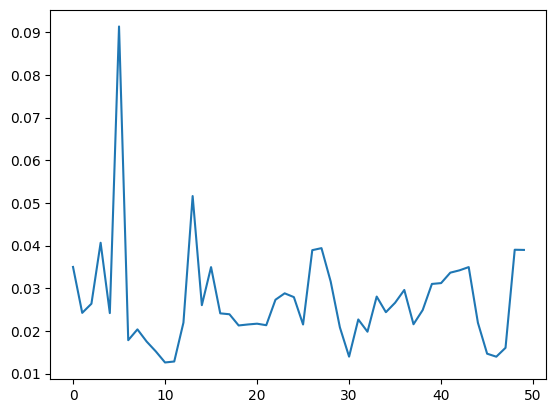

In [19]:
plt.plot(durations_s)
plt.show()

HELPER z cacheowaniem KV (key value) - poniewaz nowo generowanie wektory nie zmieniaja sie, mozemy przechowywac je w cache w postaci key - value

In [22]:
def generate_token_with_past(inputs):
    device = inputs["input_ids"].device

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]

    next_token_id = last_logits.argmax().to(device).reshape(1, 1)

    return next_token_id, outputs.past_key_values


In [23]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []

device = next_inputs["input_ids"].device

for _ in range(NEXT_TOKENS):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s.append(time.time() - t0)

    next_inputs = {
        "input_ids": next_token_id,
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
            dim=1
        ),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id[0, 0].item())
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)


0.80023193359375 s
[',', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' beauty', ' and', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', '.', ' The', ' world', ' was', ' a', ' place', ' of', ' great', ' danger', ',', ' and', ' the', ' world', ' was', ' a', ' place', ' of', ' great', ' danger']


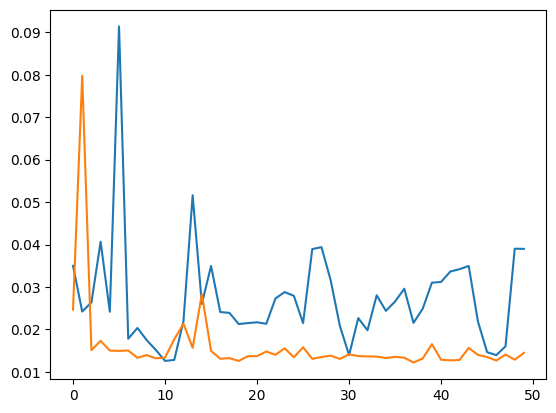

In [24]:
plt.plot(durations_s) #podstawowy HELPER niebieski kolor
plt.plot(durations_cached_s) #HELPER z KV cache pomaranczony kolor
plt.show()

In [ ]:
###ZADANIE4: Zmiencie typ srodowiska wykonawczego na T4 GPU i wykonajcie jeszcze raz kod.
###- Pojawia sie 2 bledy, mowiace o tym, ze wszystkie tensory musza byc na tym samym urzadzeniu. Popprawcie te bledy.
###podpowiedz: tensory generowane przez tokenizer oraz attention_mask (torch.tensor) musza zostac offloadowane do urzadeznia device - uzyc metody to(device)

###ZADANIE5: Czy jestescie w stanie wyjasnic, dlaczego w przypadku GPU (T4 GPU) w zasadzie nie ma znaczenie uzycie KV cache?

T4 ma bardzo małą przepustowość pamięci (Memory Bandwidth)
To jest klucz.

T4: ~320 GB/s

A100: ~1555 GB/s

H100: ~3350 GB/s

KV‑cache przyspiesza modele tylko wtedy, gdy GPU potrafi szybko odczytywać i zapisywać duże macierze K i V.
Na T4 przepustowość jest tak niska, że:

czas odczytu KV‑cache ≈ czas ponownego przeliczenia attention bez cache

Czyli zysk znika.

# **Mechanizm atencji**

W tej sekcji znajdziesz 6 krótkich zadań dotyczących mechanizmu atencji i positional encoding.

> Wskazówka: każde zadanie ma przygotowany **szkielet kodu** z miejscami na uzupełnienie (`TODO`).

---

## Zadanie 1 (teoretyczne): Jak mnożenie macierzy Q, K, V buduje atencję?

**Polecenie:** Wyjaśnij własnymi słowami, jak iloczyny macierzy **QKᵀ** i późniejsze ważenie macierzą **V** tworzą mechanizm atencji.
W wyjaśnieniu uwzględnij:
- rolę macierzy **Q** (Query), **K** (Key), **V** (Value),
- interpretację elementów macierzy \(QK^T\) jako podobieństw,
- skalowanie przez \(\sqrt{d_k}\),
- działanie `softmax` i powstanie wag,
- końcowe ważenie wartości w \(\text{softmax}(QK^T/\sqrt{d_k})V\).

**Napisz odpowiedź tekstową w tej komórce (poniżej).**


*Twoja odpowiedź:*



In [ ]:
# [Zadanie 1: kod pomocniczy]
# Poniższy przykład ilustruje kroki obliczeń atencji dla małych macierzy.
# Uruchom, aby zobaczyć kolejne etapy – możesz modyfikować wartości i obserwować wpływ.

import torch
import torch.nn.functional as F

torch.manual_seed(42)

# N=liczba tokenów, d_k=wymiar cech
N, d_k = 4, 3
Q = torch.randn(N, d_k)
K = torch.randn(N, d_k)
V = torch.randn(N, d_k)

print("Q=\n", Q)
print("K=\n", K)
print("V=\n", V)

# 1) Surowe podobieństwa
scores = Q @ K.T
print("\n[1] QK^T =\n", scores)

# 2) Skalowanie
scores_scaled = scores / (d_k ** 0.5)
print("\n[2] QK^T / sqrt(d_k) =\n", scores_scaled)

# 3) Softmax (po wierszach)
weights = F.softmax(scores_scaled, dim=-1)
print("\n[3] softmax(...) = (wagi atencji)\n", weights)
print("Wiersze sumują się do 1:", weights.sum(dim=-1))

# 4) Ważenie wartości V
out = weights @ V
print("\n[4] Wyjście atencji = softmax(QK^T/sqrt(d_k)) V =\n", out)


## Zadanie 2: Dodaj skalowanie \(1/\sqrt{d_k}\)

Masz szkic funkcji *scaled dot‑product attention*. **Drobna poprawka**: w miejscu oznaczonym `TODO` dodaj skalowanie wyników przez `1/sqrt(d_k)` **przed** softmaxem.


In [ ]:
import torch
import torch.nn.functional as F

def attention_no_scale(Q, K, V):
    # ZWRACA: (out, weights)
    # TODO: dodaj skalowanie 1/sqrt(d_k) przed softmaxem
    d_k = Q.size(-1)
    scores = Q @ K.T                    # [N, N]
    # TODO: scores = scores / (d_k ** 0.5)
    weights = F.softmax(scores, dim=-1) # po wierszach
    out = weights @ V
    return out, weights

torch.manual_seed(0)
Q = torch.randn(4, 3); K = torch.randn(4, 3); V = torch.randn(4, 3)
out, w = attention_no_scale(Q, K, V)
print("Wyjście (bez skalowania):\n", out)
print("Wagi (bez skalowania):\n", w)


## Zadanie 3: Dodaj maskę atencji (causal lub padding)

**Drobna poprawka:** Uzupełnij obsługę maski w funkcji atencji.
- Jeżeli `mask` ma wartość 0 w pozycji \((i,j)\), to *zabroń* uwagi na \(j\) z \(i\) – ustaw tam dużą ujemną wartość **przed** softmaxem.


In [ ]:
import torch
import torch.nn.functional as F

def attention_with_mask(Q, K, V, mask=None):
    # ZWRACA: (out, weights)
    # mask: tensor [N, N] z wartościami 1 (dozwolone) lub 0 (zabronione)
    # TODO: zastosuj maskę PRZED softmaxem (użyj -1e9 dla miejsc zabronionych)
    d_k = Q.size(-1)
    scores = (Q @ K.T) / (d_k ** 0.5)
    if mask is not None:
        # TODO: scores = scores.masked_fill(mask == 0, -1e9)
        pass
    weights = F.softmax(scores, dim=-1)
    out = weights @ V
    return out, weights

# Przykład maski "causal" (trójkąt dolny)
N = 4
causal = torch.tril(torch.ones(N, N))
torch.manual_seed(1)
Q = torch.randn(N, 3); K = torch.randn(N, 3); V = torch.randn(N, 3)
out_m, w_m = attention_with_mask(Q, K, V, mask=causal)
print("Wagi (z maską causal):\n", w_m)


## Zadanie 4: Uproszczone Multi‑Head (2 głowy)

**Drobna poprawka:** Uzupełnij funkcję, by:
1. Rozdzielić Q, K, V na 2 głowy (połowa wymiaru na głowę),
2. policzyć atencję niezależnie dla każdej głowy,
3. scalić wyniki `torch.cat([...], dim=-1)`.

Załóż, że wymiar wejściowy jest parzysty.


In [ ]:
import torch
import torch.nn.functional as F

def split_heads(x, num_heads=2):
    # x: [N, d_model]
    N, d_model = x.shape
    assert d_model % num_heads == 0, "d_model musi być podzielny przez liczbę głów"
    d_head = d_model // num_heads
    # [N, num_heads, d_head]
    return x.view(N, num_heads, d_head)

def attention_simple(Q, K, V):
    d_k = Q.size(-1)
    scores = (Q @ K.T) / (d_k ** 0.5)
    weights = F.softmax(scores, dim=-1)
    return weights @ V, weights

def multi_head_two(Q, K, V):
    # TODO:
    # - rozdziel Q,K,V na 2 głowy,
    # - policz attention_simple na każdej głowie,
    # - sklej wyniki po ostatnim wymiarze i zwróć.
    # ZWRACA: (out, [weights_head0, weights_head1])
    pass

torch.manual_seed(123)
Q = torch.randn(4, 6); K = torch.randn(4, 6); V = torch.randn(4, 6)
# out, (w0, w1) = multi_head_two(Q, K, V)  # po uzupełnieniu odkomentuj
# print("Wyjście Multi-Head (2):\n", out.shape)


## Zadanie 5: Dodaj sinusoidalny *positional encoding* do wejść

**Drobna poprawka:** Zaimplementuj funkcję `positional_encoding` i dodaj wyniki do `X` przed obliczeniem atencji.
Użyj wzoru:
\[
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right),\quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
\]


In [ ]:
import math
import torch

def positional_encoding(n_pos, d_model):
    # ZWRACA: tensor [n_pos, d_model]
    # TODO: zaimplementuj sinusoidalny PE zgodnie z podanym wzorem.
    raise NotImplementedError

# Przygotuj sztuczne "wejścia" X oraz Q=K=V = X (self-attention)
N, d_model = 8, 6
torch.manual_seed(7)
X = torch.randn(N, d_model)

# TODO: X_pe = X + positional_encoding(N, d_model)
# TODO: out_pe, w_pe = attention_simple(X_pe, X_pe, X_pe)

# print("Wyjście z PE:\n", out_pe)
# print("Wagi z PE (kształt):", w_pe.shape)


## Zadanie 6: Zwizualizuj mapę wag atencji (matplotlib)

**Drobna poprawka:** Po obliczeniu wag `weights` narysuj mapę (heatmapę) z użyciem **matplotlib** (bez seaborn).
- Skorzystaj z `plt.imshow(weights.detach().numpy(), aspect='auto')`
- Dodaj tytuł i opisy osi.


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(21)
Q = torch.randn(6, 4); K = torch.randn(6, 4); V = torch.randn(6, 4)
d_k = Q.size(-1)
weights = F.softmax((Q @ K.T) / (d_k ** 0.5), dim=-1)

# TODO: użyj matplotlib do narysowania heatmapy wag
# Przykład:
# plt.figure(figsize=(5,4))
# plt.imshow(weights.detach().numpy(), aspect='auto')
# plt.title("Mapa wag atencji")
# plt.xlabel("Keys")
# plt.ylabel("Queries")
# plt.colorbar()
# plt.show()


# **GPT2 fine-tuning**
Ćwiczenie bedzie polegalo na wytrenowaniu modelu na zestawie danym IMBD, tak azeby nauczyl sie klasyfikowac emocje zwiazanie z opiniami o filmach (ktore pojawily sie w komentarzach).

In [ ]:
#Instalacja pakietow
#W przypadku wystapienia bledu o niekompatybilnosci wersji fsspec, po prostu zignorujcie go.
!pip install h5py
!pip install typing-extensions
!pip install wheel
!pip install transformers torch datasets

In [ ]:
#Załadowanie datasetu.
from datasets import load_dataset
dataset_raw = load_dataset("imdb")
dataset = dataset_raw

In [ ]:
#załadowanie tokenizera i przepuszczenie datasetu przez tokenizer, aby otrzymac sekwencje tokenow (inferencja i trening/fine-tuning korzysta z tokenow)
###ZADANIE1: Wyjasnijnie w maksymalnie 250 slowach co oznacza padding oraz truncation. Dlaczego stosuje sie je w definicji funkcji tokenizera?
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
def tokenizer_func(input_ds):
    return tokenizer(input_ds["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenizer_func, batched=True)

In [ ]:
#Zaladowanie biblioteki GPT2 do klasyfikacji oraz załadowanie modelu
###ZADANIE2: Opiszcie w maksymalnie 1000 słowach czym jest GPT2ForSequenceClassification ora jego działanie. Pomocny link: https://www.huggingface.co/transformers/v4.2.2/model_doc/gpt2.html#gpt2forsequenceclassification
from transformers import GPT2ForSequenceClassification
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2).to(device)
# Define the padding token for the model configuration
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
#Inicjalizacja funkcji trenera i rozpoczecie treningu. Poeksperymentujcie z parametrem per_device_train_batch_size. Juz o tym wspominalem, ze jest to batchowanie danych wejsciowych do treningu - im wiekszy size, tym wiecej GPu VRAM potrzeba, ale tym szybszy trening, poniewaz nie tracimy czasu na najbardziej kosztowna czasowo operacje polegajaca na przeslaniu danych do VRAM.
###Zadanie3: Utworzcie konto w https://wandb.ai/home - jest to narzedzie Observability trenera. Generuje URL, pod ktorym mozna sledzic postepy treningu modelu.
###Po utworzeniu konta w wandb.ai, nalezy wygenerowac API key (nalezy stworzyc nowy projekt - w nowym projekcie API key wygeneruje sie automatycznie)
from transformers import Trainer, TrainingArguments
red_factor = 0.1
tr_ds_len = int((tokenized_datasets["train"].shape[0])*red_factor)
ev_ds_len = int((tokenized_datasets["train"].shape[0])*red_factor)

args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"].select(range(tr_ds_len)),
    eval_dataset=tokenized_datasets["test"].select(range(ev_ds_len)),
)

In [ ]:
#Uruchomienie trenera. Fine-tuning odbywa sie tylko na probce train datasetu
trainer.train()

In [ ]:
#Instalacja akceleratorow przyspieszajacych (teoretycznie) dzialanie inferencji. Krok opcjonalny
!pip install accelerate
!pip install transformers torch -U
# Uruchomcie tylko raz, zrestartujcie i juz wiecej nie wykonujcie tego kodu (chyba ze zmieniacie startujecie srodowisko uruchomieniowe na nowo)

In [ ]:
#Wykonaj ewaluacje modelu (Dokladnosc modelu na bazie probki danych eval, ktore nie byly wykorzystane w fine-tuningu)
###ZADANIE4: Zinterpretujcie wyniki wyswietlone przez eval modelu
trainer.evaluate()

In [ ]:
###ZADANIE5: Przetestujcie model da kilku (5-10) wybranych sentencji i zapiszcie wynik klasyfikacji
def get_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    outputs = model(**inputs)
    #prediction_sf = outputs.logits.softmax(-1).tolist()[0]
    prediction = outputs.logits.argmax(-1).item()
    return "pozytywna" if prediction == 1 else "negatywna"

sentence = "I'm not a big fan of this movie. I do not want to see it anymore"
print("Opinia jest: ", get_sentiment(sentence))

In [ ]:
###ZADANIE6: Zapewne zauważyliście, że nieważne co wpiszenie w pole sentence, i tak zawsze odpowiedz z modelu jest "negatywna".
###Czy jestescie w stanie wyjasnic, dlaczego fine-tuning modelu spowodowal, ze model i tak zawsze generalizuje do jednej odpowiedzi? Opiszcie swoje wytlumaczenie w max 250 slowach
###Wskazowka: Probem zbyt duzej generalizacji modelu jest bardzo czesty i lezy najczesniej w danych ... Sprawdzcie w danych co jest nie tak (chodzi o dane, ktore trafily do subsetu train_datase)